# ST445 Project: International Education
- Hongjin Lin
- Candidate Number: 
- Instructor: Steven Bell
- GTA: Simon
- Submission Date: 12nd Jan, 2019

---

## Content
- Introducation and Data Description 
- Research Questions and Hypotheses
- Visualisation 
- Modelling
- Conclusion

Import necessary packages

In [1]:
# for google BigQuery
from google.cloud import bigquery
import os
import sqlite3 as sql
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="credentials.json"
client = bigquery.Client()

# for data processing and storage
import pandas as pd
import numpy as np
import math
import time
import pickle

# for data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec

## for geomap
# hack to fix missing PROJ4 env var
import os
import conda
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

## for interactive plots
from ipywidgets import interact
import plotly
import plotly.offline as offline
from plotly.offline import init_notebook_mode, iplot
from IPython.display import display, HTML

---
## I. Introduction and Data Description

- subject of the report: internatinal education
- data soucres:
    - bigquery (main)
    - world bank data bank (secondary)
- origin: world bank complied from different sources
- nature: time series, different topics of indicators
- objective: visualize and find correlations (exploratory data analysis)
- challenges and approaches to address them:
    - 3000+ indicators, some overlapping, some with very few datapoints
        - approach: 
        - 1) count # of datapoints for each indicator, 
        - 2) filter out those with too few datapoints, 
        - 3) group indicators and select interesting topics to visualize, 
        - 4) visualize data under different topics
    - for each selected indicator: 1) countries have data for different years, 2) incorrect data: e.g. year ss 21923
        - approach: 
        - 1) count # of datapoints for each year and select a period that has more datapoints, and subset the dataset based on the selected period, 
        - 2) given the period, count # of datapoints for each country and select those have data for the whole period. If # > 50, worth visualizing 
    - big dataset: can't download the whole table and upload to GitHub (100mb is the max) --> need to use bigquery --> bigquery has quota for each user (first 1T free)
        - approach:
        - 1) for each query, save the result as csv files to avoid calling the query again. (maybe use pickel to save dataframe objects)

BigQuery is a data warehousing solution provided by Google Cloud. Organisations use data warehouses to gather several sources of data into a single entity, as well as to reshape them into SQL databases with business-oriented schemas. Thus, cross-source data analysis is easily enabled. 

https://hackernoon.com/bigquery-level-up-your-queries-with-these-advanced-tricks-c87de1fde235


Get table names

In [2]:
wbed = client.dataset("world_bank_intl_education","bigquery-public-data")
table_list = [x.table_id for x in client.list_tables(wbed)]
table_list

['country_series_definitions',
 'country_summary',
 'international_education',
 'series_summary']

Print first 5 rows of each table

In [3]:
data = client.get_dataset(wbed)

table_ref = {t: data.table(t) for t in table_list}
tables = {t: client.get_table(table_ref[t]) for t in table_list}

i = 0
for table in tables:
    rows = client.list_rows(tables[table],max_results=5)
    head = [row for row in rows]
    df = pd.DataFrame(data = [list(x.values()) for x in head],\
                      columns = list(head[0].keys()))
    print("table",i,":", table, "\n", df, '\n')
    i+=1

table 0 : country_series_definitions 
   country_code  series_code                                        description
0          ALB  SP.POP.TOTL   Data sources : Institute of Statistics, Eurostat
1          AUS  SP.POP.TOTL     Data sources : Australian Bureau of Statistics
2          AUS  SP.POP.GROW      Data sources: Australian Bureau of Statistics
3          AZE  SP.POP.TOTL  Data sources : Eurostat, State Statistical Com...
4          AZE  SP.POP.GROW  Data sources: Eurostat, State Statistical Comm... 

table 1 : country_summary 
   country_code                                 short_name  \
0          ARB                                 Arab World   
1          EAP      East Asia & Pacific (developing only)   
2          EAS    East Asia & Pacific (all income levels)   
3          ECA    Europe & Central Asia (developing only)   
4          ECS  Europe & Central Asia (all income levels)   

                                  table_name  \
0                                 Arab Wor

The international education table contains data that we need to analyze. Check the size of each table.

In [7]:
for table in tables:
    active_table = tables[table]
    print('The {} table is of'.format(table), active_table.num_bytes/1048576,'MB and has',
         active_table.num_rows,'rows.')

The country_series_definitions table is of 0.04372215270996094 MB and has 613 rows.
The country_summary table is of 0.12461471557617188 MB and has 241 rows.
The international_education table is of 595.9262762069702 MB and has 5082201 rows.
The series_summary table is of 3.4572458267211914 MB and has 3665 rows.


we have 5082201 data points and 3665 indicators

- approach: 
- 1) count # of datapoints for each indicator, 
- 2) filter out those with too few datapoints, 
- 3) group indicators and select interesting topics to visualize, 
- 4) visualize data under different topics

Make table names for convenience when writing queries

In [8]:
country_summary = wbed.project + '.' + wbed.dataset_id + '.' + 'country_summary'
series_summary = wbed.project + '.' + wbed.dataset_id + '.' + 'series_summary'
international_education = wbed.project + '.' + wbed.dataset_id + '.' + 'international_education'

In [9]:
for table in tables:
    print(table, 'schema: \n', tables[table].schema, '\n')

country_series_definitions schema: 
 [SchemaField('country_code', 'STRING', 'NULLABLE', '', ()), SchemaField('series_code', 'STRING', 'NULLABLE', '', ()), SchemaField('description', 'STRING', 'NULLABLE', '', ())] 

country_summary schema: 
 [SchemaField('country_code', 'STRING', 'NULLABLE', '', ()), SchemaField('short_name', 'STRING', 'NULLABLE', '', ()), SchemaField('table_name', 'STRING', 'NULLABLE', '', ()), SchemaField('long_name', 'STRING', 'NULLABLE', '', ()), SchemaField('two_alpha_code', 'STRING', 'NULLABLE', '', ()), SchemaField('currency_unit', 'STRING', 'NULLABLE', '', ()), SchemaField('special_notes', 'STRING', 'NULLABLE', '', ()), SchemaField('region', 'STRING', 'NULLABLE', '', ()), SchemaField('income_group', 'STRING', 'NULLABLE', '', ()), SchemaField('wb_two_code', 'STRING', 'NULLABLE', '', ()), SchemaField('national_accounts_base_year', 'STRING', 'NULLABLE', '', ()), SchemaField('national_accounts_reference_year', 'INTEGER', 'NULLABLE', '', ()), SchemaField('sna_price_v

---
## II. Indicator Selection and Research Questions

1. count # of datapoints for each indicator
2. subset those with more datapoints
3. see what topics are available
4. choose topics to visualize:
    1. attainment
    2. econ and education 
    3. expenditures
    4. infra structures
    5. learning outcomes
    6. others
5. for each topic:
    1. select interesting indicators
    2. for each year, count # of datapoints and select a period with more datapoints
    3. for each country, count # of datapoints and select those with data for the whole period
    4. if countries > 50: pose research questions 


In [28]:
my_job_config = bigquery.job.QueryJobConfig()
my_job_config.dry_run = True

query = '''
SELECT 
    s.topic,
    s.series_code, 
    s.indicator_name,
    COUNT(i.indicator_code) AS counts
FROM 
    `{}` AS s
LEFT JOIN 
    `{}` AS i
ON 
    s.series_code = i.indicator_code
GROUP BY 
    s.topic,
    s.series_code, 
    s.indicator_name;
'''.format(series_summary, international_education)

my_job = client.query(query, job_config=my_job_config)
print('This query would take about',my_job.total_bytes_processed / 1048576,'MB')

This query would take about 86.92251396179199 MB


Run query, convert result to pandas dataframe, and pickle the dataframe for future use.

In [27]:
job = client.query(query)
indicators = job.to_dataframe()

pickling_on = open("indicators.pickle","wb")
pickle.dump(indicators, pickling_on)
pickling_on.close()

3665

unpickle indicators

In [40]:
pickle_off = open("indicators.pickle","rb")
indicators = pickle.load(pickle_off)
indicators.head()

topic  \
0                                 Education Equality   
1                                 Education Equality   
2                                  Learning Outcomes   
3  Economic Policy & Debt: National accounts: US$...   
4                                  Learning Outcomes   

                  series_code  \
0               UIS.ROFST.H.1   
1           HH.MICS.OOST.L.Q3   
2        LO.EGRA.ORF.KNY.6GRD   
3              NY.GDP.PCAP.CD   
4  LO.EGRA.CWPM.ZERO.AKU.2GRD   

                                      indicator_name  counts  
0  UIS: Rate of out-of-school children of primary...     127  
1  MICS: Typology of out-of-school children. Prim...      33  
2  EGRA: Oral Reading Fluency - Correct Words Rea...       1  
3                       GDP per capita (current US$)    9196  
4  EGRA: Oral Reading Fluency - Share of students...       1

In [41]:
print(indicators['counts'].describe())
indicators = indicators[indicators['counts']>1000]
len(indicators)

count     3665.000000
mean      1359.956344
std       1957.703247
min          0.000000
25%         27.000000
50%        279.000000
75%       2141.000000
max      11155.000000
Name: counts, dtype: float64


1510

In [42]:
print(indicators['topic'].nunique())
set(indicators['topic'])

23


{'Attainment',
 'Background',
 'Early Childhood Education',
 'Economic Policy & Debt: National accounts: Atlas GNI & GNI per capita',
 'Economic Policy & Debt: National accounts: US$ at constant 2010 prices: Aggregate indicators',
 'Economic Policy & Debt: National accounts: US$ at current prices: Aggregate indicators',
 'Economic Policy & Debt: Purchasing power parity',
 'Expenditures',
 'Health: Mortality',
 'Health: Population: Dynamics',
 'Health: Population: Structure',
 'Health: Risk factors',
 'Infrastructure: Communications',
 'Literacy',
 'Population',
 'Post-Secondary/Non-Tertiary',
 'Pre-Primary',
 'Primary',
 'Secondary',
 'Social Protection & Labor: Labor force structure',
 'Social Protection & Labor: Unemployment',
 'Teachers',
 'Tertiary'}

### II.i Attainment
- education rate trend by country groups
- geographic representation of education rate

In [57]:
pd.set_option('display.max_colwidth', -1)
attainment_ind = indicators.loc[indicators['topic'] == 'Attainment']
attainment_ind.sample(10)

topic              series_code  \
1887  Attainment  BAR.PRM.SCHL.75UP.FE      
3464  Attainment  PRJ.ATT.15UP.2.MA         
284   Attainment  BAR.SCHL.4549.FE          
1542  Attainment  BAR.SCHL.3539.FE          
3661  Attainment  BAR.PRM.CMPT.25UP.ZS      
2127  Attainment  PRJ.POP.2529.3.MA         
801   Attainment  BAR.PRM.SCHL.25UP.FE      
2837  Attainment  BAR.SCHL.7074.FE          
3363  Attainment  PRJ.POP.ALL.1.MF          
2983  Attainment  BAR.TER.ICMP.6064.FE.ZS   

                                                                                                               indicator_name  \
1887  Barro-Lee: Average years of primary schooling, age 75+, female                                                            
3464  Projection: Percentage of the population age 15+ by highest level of educational attainment. Lower Secondary. Male        
284   Barro-Lee: Average years of total schooling, age 45-49, female                                                            
1542  Barro-Lee: Average years of total schooling, age 35-39, female                                                            
3661  Barro-Lee: Percentage of population age 25+ with primary schooling. Completed Primary                                     
2127  Projection: Population age 25-29 in thousands by highest level of educational attainment. Upper Secondary. Male           
801   Barro-Lee: Average years of primary schooling, age 25+, female                                                            
2837  Barro-Lee: Average years of total schooling, age 70-74, female                                                            
3363  Projection: Population in thousands by highest level of educational attainment. Primary. Total                            
2983  Barro-Lee: Percentage of female population age 60-64 with tertiary schooling. Total (Incomplete and Completed Tertiary)   

      counts  
1887  1296    
3464  3173    
284   1296    
1542  1296    
3661  1296    
2127  3173    
801   1296    
2837  1296    
3363  3173    
2983  1296

In [44]:
bar_count = 0
prj_count = 0 
for ind in attainment_ind['series_code']:
    if ind.startswith('BAR'):
        bar_count += 1
    if ind.startswith('PRJ'):
        prj_count += 1
len(attainment_ind.index) - bar_count - prj_count

0

In [58]:
bar_ind = attainment_ind[attainment_ind['series_code'].str.contains('BAR')]
bar_ind.sample(10)

topic              series_code  \
162   Attainment  BAR.SEC.SCHL.2529         
1435  Attainment  BAR.TER.ICMP.2024.FE.ZS   
1145  Attainment  BAR.PRM.CMPT.15UP.FE.ZS   
1467  Attainment  BAR.NOED.2024.ZS          
2589  Attainment  BAR.TER.ICMP.4044.ZS      
2312  Attainment  BAR.TER.CMPT.2024.FE.ZS   
1819  Attainment  BAR.PRM.CMPT.7074.ZS      
1948  Attainment  BAR.TER.SCHL.7074.FE      
3448  Attainment  BAR.TER.ICMP.2529.FE.ZS   
2814  Attainment  BAR.NOED.4549.ZS          

                                                                                                               indicator_name  \
162   Barro-Lee: Average years of secondary schooling, age 25-29, total                                                         
1435  Barro-Lee: Percentage of female population age 20-24 with tertiary schooling. Total (Incomplete and Completed Tertiary)   
1145  Barro-Lee: Percentage of female population age 15+ with primary schooling. Completed Primary                              
1467  Barro-Lee: Percentage of population age 20-24 with no education                                                           
2589  Barro-Lee: Percentage of population age 40-44 with tertiary schooling. Total (Incomplete and Completed Tertiary)          
2312  Barro-Lee: Percentage of female population age 20-24 with tertiary schooling. Completed Tertiary                          
1819  Barro-Lee: Percentage of population age 70-74 with primary schooling. Completed Primary                                   
1948  Barro-Lee: Average years of tertiary schooling, age 70-74, female                                                         
3448  Barro-Lee: Percentage of female population age 25-29 with tertiary schooling. Total (Incomplete and Completed Tertiary)   
2814  Barro-Lee: Percentage of population age 45-49 with no education                                                           

      counts  
162   1296    
1435  1296    
1145  1296    
1467  1296    
2589  1296    
2312  1296    
1819  1296    
1948  1296    
3448  1296    
2814  1296

In [59]:
bar_ind[bar_ind['series_code'].str.contains('15UP')]

topic              series_code  \
177   Attainment  BAR.SEC.SCHL.15UP         
353   Attainment  BAR.PRM.ICMP.15UP.ZS      
471   Attainment  BAR.PRM.SCHL.15UP.FE      
566   Attainment  BAR.PRM.CMPT.15UP.ZS      
588   Attainment  BAR.SEC.CMPT.15UP.FE.ZS   
730   Attainment  BAR.PRM.SCHL.15UP         
846   Attainment  BAR.SCHL.15UP.FE          
1018  Attainment  BAR.TER.SCHL.15UP.FE      
1145  Attainment  BAR.PRM.CMPT.15UP.FE.ZS   
1377  Attainment  BAR.TER.ICMP.15UP.ZS      
1656  Attainment  BAR.TER.ICMP.15UP.FE.ZS   
1919  Attainment  BAR.POP.15UP.FE           
2541  Attainment  BAR.PRM.ICMP.15UP.FE.ZS   
2658  Attainment  BAR.SCHL.15UP             
2832  Attainment  BAR.NOED.15UP.FE.ZS       
2902  Attainment  BAR.SEC.CMPT.15UP.ZS      
2984  Attainment  BAR.TER.CMPT.15UP.FE.ZS   
3005  Attainment  BAR.NOED.15UP.ZS          
3047  Attainment  BAR.SEC.SCHL.15UP.FE      
3068  Attainment  BAR.SEC.ICMP.15UP.FE.ZS   
3246  Attainment  BAR.POP.15UP              
3346  Attainment  BAR.TER.SCHL.15UP         
3584  Attainment  BAR.TER.CMPT.15UP.ZS      
3658  Attainment  BAR.SEC.ICMP.15UP.ZS      

                                                                                                               indicator_name  \
177   Barro-Lee: Average years of secondary schooling, age 15+, total                                                           
353   Barro-Lee: Percentage of population age 15+ with primary schooling. Total (Incomplete and Completed Primary)              
471   Barro-Lee: Average years of primary schooling, age 15+, female                                                            
566   Barro-Lee: Percentage of population age 15+ with primary schooling. Completed Primary                                     
588   Barro-Lee: Percentage of female population age 15+ with secondary schooling. Completed Secondary                          
730   Barro-Lee: Average years of primary schooling, age 15+, total                                                             
846   Barro-Lee: Average years of total schooling, age 15+, female                                                              
1018  Barro-Lee: Average years of tertiary schooling, age 15+, female                                                           
1145  Barro-Lee: Percentage of female population age 15+ with primary schooling. Completed Primary                              
1377  Barro-Lee: Percentage of population age 15+ with tertiary schooling. Total (Incomplete and Completed Tertiary)            
1656  Barro-Lee: Percentage of female population age 15+ with tertiary schooling. Total (Incomplete and Completed Tertiary)     
1919  Barro-Lee: Population in thousands, age 15+, female                                                                       
2541  Barro-Lee: Percentage of female population age 15+ with primary schooling. Total (Incomplete and Completed Primary)       
2658  Barro-Lee: Average years of total schooling, age 15+, total                                                               
2832  Barro-Lee: Percentage of female population age 15+ with no education                                                      
2902  Barro-Lee: Percentage of population age 15+ with secondary schooling. Completed Secondary                                 
2984  Barro-Lee: Percentage of female population age 15+ with tertiary schooling. Completed Tertiary                            
3005  Barro-Lee: Percentage of population age 15+ with no education                                                             
3047  Barro-Lee: Average years of secondary schooling, age 15+, female                                                          
3068  Barro-Lee: Percentage of female population age 15+ with secondary schooling. Total (Incomplete and Completed Secondary)   
3246  Barro-Lee: Population in thousands, age 15+, total                                                                        
3346  Barro-Lee: Average years of tertiary scho

In [60]:
attainment_ind = 'BAR.NOED.15UP.ZS'

### II.ii Economics and Education 
- relationship between GDP per capita and education rate


### II.iii Education Expenditures
- who is spending more in education
- trend in education spending



### II.iv Education Infrastructures


### II.v Learning Outcomes


### II.vi Others

---
## III. Visualisation

### III.i Attainment

---
## Modelling

---
## Conclusion

Guidlines:
* Introduction and Data Description 5%
Clear explanation of the subject of the report. Origin and nature of the data well described
    * International education - world bank
    * GDP or other international development indicators 

* Formulation of research question 5%
Well articulated question addressing interesting topic.
    * education's relationship with other international development indicators
    * who is spending more in education
    * trend in education spending
    * female inclusion

* Data Acquisiton 10%
Use of API or webscraping to generate complex data set or sophisticated use of multiple data sources.
    * Big query to get all data (chose indicators first)
    * world bank or other sources to get other data to link the educational dataset

*  Data Cleaning and Shaping 30%
Good use of Pandas tools such as GroupBy, Boolean filters and cleaning methods such as dropna. Use of join or merge to handle multiple data sets. Effective use of descriptive statistics. Well structured code.
     * group data by country group (income level)

* Visualisation 30%
Effective use of wide variety of plots including some more complex (eg use of geographical data), possibly interactive plots.

* Data modelling 10%
Effective and appropriate use of modelling techniques together with performance statistics such as ROC.

* Conclusion and overall structure. 10%
Good conclusion with well structured report that reads well as a story. Evidence of critical thinking.


Create local db for queries

In [12]:
conn = sql.connect('wbed.db')

c = conn.cursor()

c.execute('''CREATE TABLE country_summary
             (country_code STRING, region STRING, income_group STRING)''')
c.execute('''CREATE TABLE international_education
             (country_name STRING, country_code STRING, indicator_name STRING, indicator_code STRING, year INTEGER, value FLOAT)''')
c.execute('''CREATE TABLE series_summary
             (series_code STRING, topic STRING, indicator_name STRING)''')

conn.commit()

countries.to_sql('country_summary', conn, if_exists='append', index = False)
int_ed.to_sql('international_education', conn, if_exists='append', index = False)
indicators.to_sql('series_summary', conn, if_exists='append', index = False)
conn.close()

Read in tables and arrange them for visualization

In [2]:
int_ed = pd.read_csv('international_education.csv',index_col=0)
countries = pd.read_csv('country_summary.csv', usecols = ['country_code','region','income_group'])
indicators = pd.read_csv('series_summary.csv', usecols = ['series_code','topic','indicator_name'])

int_ed = int_ed.dropna()
countries = countries.dropna()
indicators = indicators.dropna()

int_ed = int_ed.reset_index(drop=True)
countries = countries.reset_index(drop=True)
indicators = indicators.reset_index(drop=True)

int_ed = pd.merge(countries, int_ed, how='outer',on='country_code')

/Users/mac/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



Put country grouping information to the main international edcucation table for visualization

In [8]:
countries.head()

country_code                     region income_group
0          AFG                 South Asia   Low income
1          ERI         Sub-Saharan Africa   Low income
2          HTI  Latin America & Caribbean   Low income
3          MMR        East Asia & Pacific   Low income
4          PRK        East Asia & Pacific   Low income

A glimpse into two main tables

In [5]:
int_ed = pd.merge(countries, int_ed, how='outer',on='country_code')

In [10]:
int_ed.head()

country_code      region income_group country_name  \
0          AFG  South Asia   Low income  Afghanistan   
1          AFG  South Asia   Low income  Afghanistan   
2          AFG  South Asia   Low income  Afghanistan   
3          AFG  South Asia   Low income  Afghanistan   
4          AFG  South Asia   Low income  Afghanistan   

                                      indicator_name        indicator_code  \
0  Barro-Lee: Average years of tertiary schooling...  BAR.TER.SCHL.3034.FE   
1                          Population, age 10, total     SP.POP.AG10.TO.UN   
2                      Population, ages 13-16, total     SP.POP.1316.TO.UN   
3  Out-of-school youth of upper secondary school ...       UIS.OFST.3.M.CP   
4                            Population, age 6, male     SP.POP.AG06.MA.UN   

   year       value  
0  2000        0.11  
1  2010   836013.00  
2  2012  3128514.00  
3  2014   438735.00  
4  1990   202653.00

In [11]:
indicators.head()

series_code       topic  \
0  BAR.NOED.1519.FE.ZS  Attainment   
1     BAR.NOED.1519.ZS  Attainment   
2  BAR.NOED.15UP.FE.ZS  Attainment   
3     BAR.NOED.15UP.ZS  Attainment   
4  BAR.NOED.2024.FE.ZS  Attainment   

                                      indicator_name  
0  Barro-Lee: Percentage of female population age...  
1  Barro-Lee: Percentage of population age 15-19 ...  
2  Barro-Lee: Percentage of female population age...  
3  Barro-Lee: Percentage of population age 15+ wi...  
4  Barro-Lee: Percentage of female population age...

We currently have many indicators - 3665 of them, but many of them do not have a lot of datapoints. Check availability of each indicators.

In [336]:
count_series = int_ed.groupby(['indicator_code'],as_index=False)['value'].count()
counts = pd.DataFrame(count_series)
counts.columns = ['series_code','counts']

new_indicators = pd.merge(indicators, counts, on='series_code')

summary = new_indicators['counts'].describe()
print(summary)

new_indicators = new_indicators[new_indicators['counts']>1000]#summary['75%']]
len(new_indicators)

count     3615.000000
mean      1378.766252
std       1964.608036
min          1.000000
25%         28.000000
50%        299.000000
75%       2231.500000
max      11155.000000
Name: counts, dtype: float64


1510

In [41]:
conn = sql.connect('wbed.db')

c = conn.cursor()

c.execute('''SELECT s.*, COUNT(i.indicator_code) AS counts
FROM series_summary AS s
LEFT JOIN international_education AS i
ON s.series_code == i.indicator_code
GROUP BY i.indicator_code;''')
test = c.fetchall()

conn.close()

In [49]:
test_df = pd.DataFrame.from_records(test, columns = ['series_code','topic','indicator_name','counts'])
print(test_df['counts'].describe())
indicators = test_df[test_df['counts']>1000]
len(indicators)

count     3616.000000
mean      1378.384956
std       1964.470099
min          0.000000
25%         28.000000
50%        299.000000
75%       2231.250000
max      11155.000000
Name: counts, dtype: float64


1510

In [25]:
counts = pd.DataFrame.from_records(test, columns =['series_code','counts'])
new_indicators = pd.merge(indicators, counts, on='series_code')

summary = new_indicators['counts'].describe()
print(summary)

new_indicators = new_indicators[new_indicators['counts']>1000]#summary['75%']]
len(new_indicators)

count     3615.000000
mean      1378.766252
std       1964.608036
min          1.000000
25%         28.000000
50%        299.000000
75%       2231.500000
max      11155.000000
Name: counts, dtype: float64


1510

Only consider indicators that have more than the 3rd quantile, which reduces the number of indicators to 916.

> There are 23 unique topics that we can focus on. We choose the following:
1. Attainment
2. Economic Policy & Debt: National accounts: US$ at current prices: Aggregate indicators
3. Expenditures
4. Infrastructure: Communications
5. Teachers
6. Learning Outcomes

## Attainment

In [30]:
attainment_ind = new_indicators.loc[new_indicators['topic'] == 'Attainment']
attainment_ind.sample(10)

series_code       topic  \
284   BAR.TER.CMPT.4044.FE.ZS  Attainment   
274   BAR.TER.CMPT.2024.FE.ZS  Attainment   
157          BAR.SCHL.2529.FE  Attainment   
3473        PRJ.ATT.4064.1.MF  Attainment   
1679        PRJ.POP.ALL.S1.FE  Attainment   
1625       PRJ.POP.1519.S1.FE  Attainment   
3461        PRJ.ATT.2039.1.MF  Attainment   
1670         PRJ.POP.ALL.3.FE  Attainment   
3091       PRJ.ATT.15UP.S1.MA  Attainment   
133      BAR.PRM.SCHL.3539.FE  Attainment   

                                         indicator_name  counts  
284   Barro-Lee: Percentage of female population age...    1296  
274   Barro-Lee: Percentage of female population age...    1296  
157   Barro-Lee: Average years of total schooling, a...    1296  
3473  Projection: Percentage of the population age 4...    3173  
1679  Projection: Population in thousands by highest...    3173  
1625  Projection: Population age 15-19 in thousands ...    3173  
3461  Projection: Percentage of the population age 2...    3173  
1670  Projection: Population in thousands by highest...    3173  
3091  Projection: Percentage of the population age 1...    3173  
133   Barro-Lee: Average years of primary schooling,...    1296

Seems to only have Barro-Lee and Projection. Let's check - true

In [ ]:
bar_count = 0
prj_count = 0 
for ind in attainment_ind['series_code']:
    if ind.startswith('BAR'):
        bar_count += 1
    if ind.startswith('PRJ'):
        prj_count += 1
len(attainment_ind.index) - bar_count - prj_count

### Barro-Lee

In [33]:
# set to display indicator names fully
bar = attainment_ind[:bar_count].sort_values('counts', ascending = False)
bar.head()

series_code       topic  \
0     BAR.NOED.1519.FE.ZS  Attainment   
247  BAR.SEC.SCHL.2529.FE  Attainment   
245  BAR.SEC.SCHL.2024.FE  Attainment   
244     BAR.SEC.SCHL.2024  Attainment   
243  BAR.SEC.SCHL.15UP.FE  Attainment   

                                        indicator_name  counts  
0    Barro-Lee: Percentage of female population age...    1296  
247  Barro-Lee: Average years of secondary schoolin...    1296  
245  Barro-Lee: Average years of secondary schoolin...    1296  
244  Barro-Lee: Average years of secondary schoolin...    1296  
243  Barro-Lee: Average years of secondary schoolin...    1296

There are five groups: 
1. no education
2. population 
3. primary school
4. secondary school
5. tertiary school

disaggregated by age. 

We will look at one age group for now: 15+

In [34]:
bar_selected = bar[bar['series_code'].str.contains('15UP')]
bar_selected.head()

series_code       topic  \
243     BAR.SEC.SCHL.15UP.FE  Attainment   
242        BAR.SEC.SCHL.15UP  Attainment   
183     BAR.SEC.CMPT.15UP.ZS  Attainment   
182  BAR.SEC.CMPT.15UP.FE.ZS  Attainment   
213     BAR.SEC.ICMP.15UP.ZS  Attainment   

                                        indicator_name  counts  
243  Barro-Lee: Average years of secondary schoolin...    1296  
242  Barro-Lee: Average years of secondary schoolin...    1296  
183  Barro-Lee: Percentage of population age 15+ wi...    1296  
182  Barro-Lee: Percentage of female population age...    1296  
213  Barro-Lee: Percentage of population age 15+ wi...    1296

Let's look at percentage of popoluation age 15+ with no education for now.

In [35]:
conn = sql.connect('wbed.db')

c = conn.cursor()

c.execute('''SELECT i.country_code, i.country_name, c.region, c.income_group, i.year, i.value
FROM international_education AS i 
LEFT JOIN country_summary AS c
ON i.country_code = c.country_code
WHERE i.indicator_code == 'BAR.NOED.15UP.ZS';''')
test = c.fetchall()

conn.close()

In [3]:
per_noed = int_ed[int_ed['indicator_code'] == 'BAR.NOED.15UP.ZS']

In [9]:
region_noed = per_noed.groupby(['region','year']).mean()
income_noed = per_noed.groupby(['income_group','year']).mean()

In [4]:
regions = set(per_noed['region'])
print(len(regions), 'region groups:\n', regions)

income = set(per_noed['income_group'])
print(len(income),'income groups:\n', income)

7 region groups:
 {'South Asia', 'North America', 'Europe & Central Asia', 'East Asia & Pacific', 'Latin America & Caribbean', 'Sub-Saharan Africa', 'Middle East & North Africa'}
5 income groups:
 {'Lower middle income', 'High income: nonOECD', 'Low income', 'Upper middle income', 'High income: OECD'}


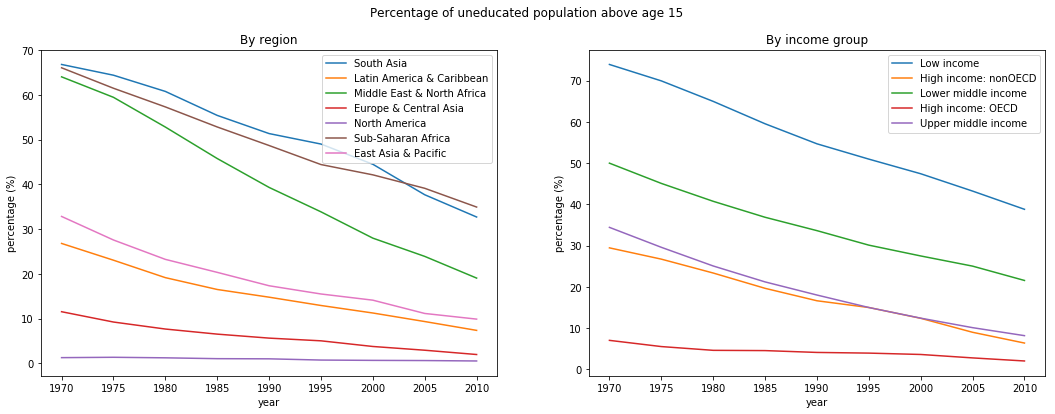

In [25]:
plt.figure(figsize=(18,6))
plt.suptitle('Percentage of uneducated population above age 15')

plt.subplot(1,2,1)
plt.title('By region')
for region in regions:
    plt.plot(region_noed.loc[(region)])
plt.ylabel('percentage (%)')
plt.xlabel('year')
plt.legend(regions)

plt.subplot(1,2,2)
plt.title('By income group')
for group in income:
    plt.plot(income_noed.loc[(group)])
plt.ylabel('percentage (%)')
plt.xlabel('year')
plt.legend(income)

plt.show()

Map view on 2010 data:

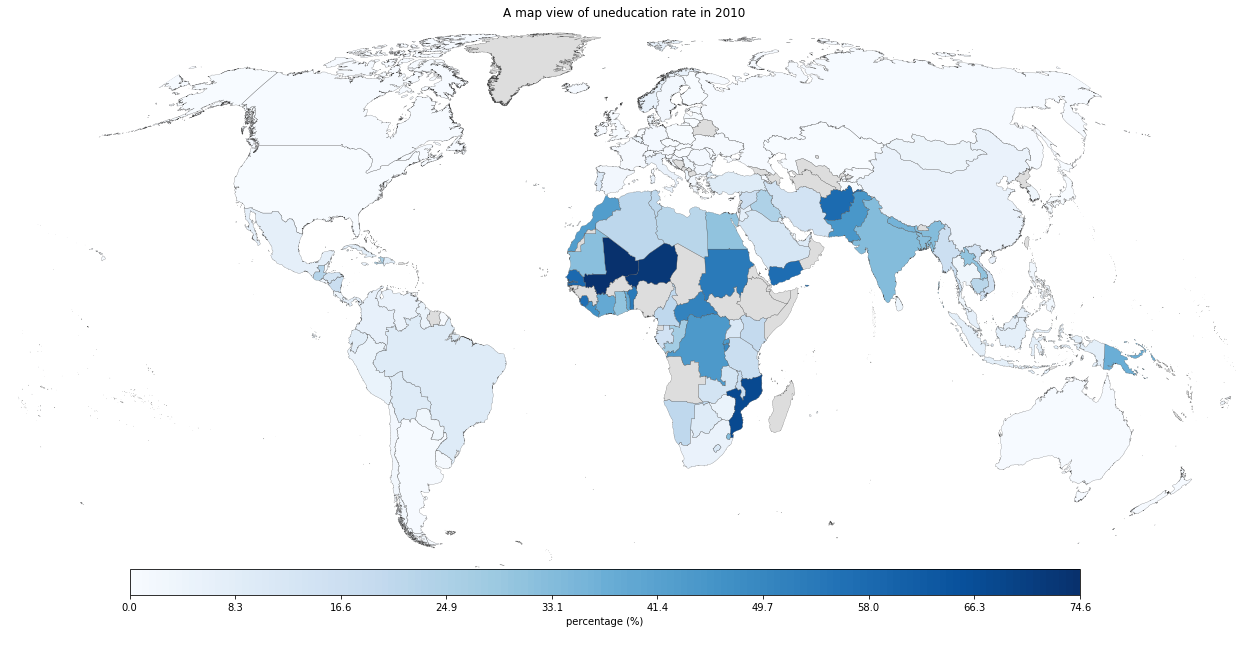

In [143]:
# subset 2010 data
geo_df = per_noed[per_noed['year'] == 2010][['country_code','value']]
v_min = geo_df['value'].min()
v_max = geo_df['value'].max()
bins = np.linspace(v_min, v_max, num_colors)
geo_df['bin'] = np.digitize(geo_df['value'], bins) - 1

# initialize map
num_colors = per_noed['country_code'].nunique()
cm = plt.get_cmap('Blues')
scheme = [cm(i / num_colors) for i in range(num_colors)]

fig = plt.figure(figsize=(22, 12))
ax = fig.add_subplot(111, facecolor = 'w', frame_on=False)
plt.title('A map view of uneducation rate in 2010')

m = Basemap(lon_0=0, projection='robin')
m.drawmapboundary(color='w')
shapefile = 'shapefiles/ne_10m_admin_0_countries'
m.readshapefile(shapefile, 'units', color='#444444', linewidth=.2)

# fill area with data
for info, shape in zip(m.units_info, m.units):
    country = info['ADM0_A3']
    try:
        color = scheme[int(geo_df[geo_df['country_code'] == country]['bin'])]
    except:
        color = '#dddddd'
    patches = [Polygon(np.array(shape), True)]
    pc = PatchCollection(patches)
    pc.set_facecolor(color)
    ax.add_collection(pc)
    
ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)
ax_legend = fig.add_axes([0.2, 0.2, 0.6, 0.03], zorder=3)
cmap = mpl.colors.ListedColormap(scheme)
cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=np.linspace(v_min, v_max, 10), 
                               boundaries=bins, orientation='horizontal')
cb.ax.set_xticklabels([str(round(i,1)) for i in np.linspace(v_min, v_max, 10)])
cb.set_label('percentage (%)')

plt.show()

(Map interactive view)

In [141]:
num_colors = per_noed['country_code'].nunique()
cm = plt.get_cmap('Blues')
scheme = [cm(i / num_colors) for i in range(num_colors)]
# shapefile downloaded from http://www.naturalearthdata.com/downloads/10m-cultural-vectors/ 
shapefile = 'shapefiles/ne_10m_admin_0_countries'
m = Basemap(lon_0=0, projection='robin')

def plot_func(year):
    # get year data
    geo_df = per_noed[per_noed['year'] == year][['country_code','value']]
    v_min = geo_df['value'].min()
    v_max = geo_df['value'].max()
    bins = np.linspace(v_min, v_max, num_colors)
    geo_df['bin'] = np.digitize(geo_df['value'], bins) - 1
    
    # draw map
    print('graph loading...')
    fig = plt.figure(figsize=(22, 12))
    ax = fig.add_subplot(111, facecolor = 'w', frame_on=False)
    
    plt.title('A map view of uneducation rate in {}'.format(year))
    
    m.drawmapboundary(color='w')
    m.readshapefile(shapefile, 'units', color='#444444', linewidth=.2)
    #map_info = {m.units_info[i]['ADM0_A3']:m.units[i] for i in range(len(m.units_info))}
  
    #fill in data
    for info, shape in zip(m.units_info, m.units):
    #for country, shape in map_info.items():
        country = info['ADM0_A3']
        try:
            color = scheme[int(geo_df[geo_df['country_code'] == country]['bin'])]
        except:
            color = '#dddddd'
        patches = [Polygon(np.array(shape), True)]
        pc = PatchCollection(patches)
        pc.set_facecolor(color)
        ax.add_collection(pc)
    
    ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)
    ax_legend = fig.add_axes([0.2, 0.2, 0.6, 0.03], zorder=3)
    cmap = mpl.colors.ListedColormap(scheme)
    cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=np.linspace(v_min, v_max, 10), 
                                   boundaries=bins, orientation='horizontal')
    cb.ax.set_xticklabels([str(round(i,1)) for i in np.linspace(v_min, v_max, 10)])
    cb.set_label('percentage (%)')

    print('finish loading:')

    plt.show()

In [142]:
print('-----click on slide bar to select data for a specific year (from 1970 to 2010, default is 1990): -----')

interact(plot_func, year = (1970,2010,5));


-----click on slide bar to select data for a specific year (from 1970 to 2010, default is 1990): -----


interactive(children=(IntSlider(value=1990, description='year', max=2010, min=1970, step=5), Output()), _dom_c…

## Economics and education

In [61]:
econ_ind = indicators.loc[indicators['topic'] == 'Economic Policy & Debt: National accounts: US$ at current prices: Aggregate indicators']
econ_ind

topic  \
3     Economic Policy & Debt: National accounts: US$ at current prices: Aggregate indicators   
580   Economic Policy & Debt: National accounts: US$ at current prices: Aggregate indicators   
2788  Economic Policy & Debt: National accounts: US$ at current prices: Aggregate indicators   

         series_code                indicator_name  counts  
3     NY.GDP.PCAP.CD  GDP per capita (current US$)  9196    
580   NY.GNP.MKTP.CD  GNI (current US$)             8800    
2788  NY.GDP.MKTP.CD  GDP (current US$)             9199

In [5]:
econ_df = int_ed[int_ed['indicator_code'] == 'NY.GDP.PCAP.CD']
econ_df = econ_df.rename(columns = {'value':'gdp_pc'})
econ_df = econ_df[['country_code','country_name','income_group','region','year','gdp_pc']]

econ_df_countries = econ_df[econ_df['country_code'].isin(countries['country_code'])]
econ_df_groups =  econ_df[~econ_df['country_code'].isin(countries['country_code'])]

Make bubble graph:
- x: gdp per capita
- y: uneducation rate
- points color: region
- bubble size: expenditures?

Get population data: https://data.worldbank.org/indicator/SP.POP.TOTL, downloaded csv file

In [6]:
pop_df = pd.read_csv('world_pop.csv', header=2)
years_int = list(np.arange(1970,2011,5))
years = [str(year) for year in years_int]

cols = ['Country Code'] + years
pop_df = pop_df[cols]
pop_df = pd.melt(pop_df, id_vars=['Country Code'], value_vars=years)
pop_df = pop_df.rename(columns={'Country Code':'country_code', 'variable':'year','value':'pop'})
pop_df['year'] = pop_df['year'].astype(int)
pop_df.head()

country_code  year         pop
0          ABW  1970     59063.0
1          AFG  1970  11126123.0
2          AGO  1970   6776381.0
3          ALB  1970   2135479.0
4          AND  1970     24276.0

In [7]:
bubble_df = pd.merge(econ_df, pop_df, how='inner', on=['country_code','year'])

per_noed1 = per_noed[['country_code','year','value']]
per_noed1 = per_noed1.rename(columns={'value':'per_noed'})

bubble_df = pd.merge(bubble_df, per_noed1, how='inner', on=['country_code','year'])

year_counts = bubble_df.groupby(['country_code'])['year'].count()
sub_countries = list(year_counts[year_counts == 9].index)
bubble_df = bubble_df[bubble_df['country_code'].isin(sub_countries)]
bubble_df['per_ed'] = 100-bubble_df['per_noed']
bubble_df = bubble_df.drop(columns=['per_noed'])
print('There are',bubble_df['country_code'].nunique(),'countries that have three data from 1970 to 2010')
bubble_df.head()

There are 99 countries that have three data from 1970 to 2010


country_code country_name         income_group                     region  \
12          GTM    Guatemala  Lower middle income  Latin America & Caribbean   
13          GTM    Guatemala  Lower middle income  Latin America & Caribbean   
14          GTM    Guatemala  Lower middle income  Latin America & Caribbean   
15          GTM    Guatemala  Lower middle income  Latin America & Caribbean   
16          GTM    Guatemala  Lower middle income  Latin America & Caribbean   

    year       gdp_pc         pop  per_ed  
12  1975   566.685443   6433728.0   38.71  
13  1990   825.807388   9263813.0   60.66  
14  1995  1408.032180  10408489.0   64.33  
15  2005  2077.834380  13096028.0   67.60  
16  1970   338.682043   5621792.0   34.34

Seperate countries into regions first

In [9]:
# offline plotly: connected to notebook
#init_notebook_mode(connected=True)
offline.init_notebook_mode()

# make figure
figure = {'data': [],'layout': {},'frames': []}

# fill in most of layout
figure['layout']['title'] = 'Bubble chart animation'
figure['layout']['xaxis'] = {'range': [0, 110], 'title': 'Percentage of population above age 15 that are educated'}
figure['layout']['yaxis'] = {'title': 'GDP per Capita', 'type': 'log'}
figure['layout']['hovermode'] = 'closest'

# add slider
figure['layout']['sliders'] = {'args': ['transition', {'duration': 450,'easing': 'cubic-in-out'}],
                               'initialValue': '1970','plotlycommand': 'animate','values': years,'visible': True}

sliders_dict = {'active': 0,'yanchor': 'top','xanchor': 'left','currentvalue': {'font': {'size': 20},
                                                                                'prefix': 'Year:',
                                                                                'visible': True,
                                                                                'xanchor': 'right'},
                'transition': {'duration': 450, 'easing': 'cubic-in-out'}, 'pad': {'b': 10, 't': 50},
                'len': 0.9, 'x': 0.1, 'y': 0, 'steps': []}

# add buttons for play and pause
figure['layout']['updatemenus'] = [{'buttons': [{'args': [None, {'frame': {'duration': 450, 'redraw': False},
                                                                 #'fromcurrent': True, 
                                                                 'transition': {'duration': 450, 'easing': 'quadratic-in-out'}}],
                                                 'label': 'Play','method': 'animate'},
                                                {'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                                                                   'transition': {'duration': 0}}],
                                                 'label': 'Pause','method': 'animate'}],
                                    'direction': 'left', 'pad': {'r': 10, 't': 87}, 'showactive': False,
                                    'type': 'buttons', 'x': 0.1, 'xanchor': 'right', 'y': 0, 'yanchor': 'top'}]

# make initial data
year = 1970
for group in regions:
    bubble_by_year = bubble_df[bubble_df['year'] == year]
    bubble_by_year_and_group = bubble_by_year[bubble_by_year['region'] == group]

    data_dict = {'x': list(bubble_by_year_and_group['per_ed']),
                 'y': list(bubble_by_year_and_group['gdp_pc']),
                 'mode': 'markers',
                 'text': list(bubble_by_year_and_group['country_name']),
                 'marker': {'sizemode': 'area','sizeref': 200000,'size': list(bubble_by_year_and_group['pop'])},
                 'name': group}
    figure['data'].append(data_dict)

# make frames
for year in years:
    frame = {'data': [], 'name': str(year)}
    for group in regions:
        bubble_by_year = bubble_df[bubble_df['year'] == int(year)]
        bubble_by_year_and_group = bubble_by_year[bubble_by_year['region'] == group]

        data_dict = {'x': list(bubble_by_year_and_group['per_ed']),
                     'y': list(bubble_by_year_and_group['gdp_pc']),
                     'mode': 'markers',
                     'text': list(bubble_by_year_and_group['country_name']),
                     'marker': {'sizemode': 'area','sizeref': 200000,'size': list(bubble_by_year_and_group['pop'])},
                     'name': group}
        frame['data'].append(data_dict)

    figure['frames'].append(frame)
    slider_step = {'args': [[year], {'frame': {'duration': 450, 'redraw': False},
                                     'mode': 'immediate',
                                     'transition': {'duration': 450}}],
                   'label': year,'method': 'animate'}
    sliders_dict['steps'].append(slider_step)

# update slider
figure['layout']['sliders'] = [sliders_dict]

# plot
#iplot(figure)
offline.iplot(figure)

> Afria left behind and diverse, south asia also left behind, east asia caught out the fastest, europe and north america up there all the time

## Education Expenditures

In [156]:
exp_ind = new_indicators.loc[new_indicators['topic'] == 'Expenditures'].sort_values('counts',ascending = False)
exp_ind.head()

series_code         topic  \
1246  SE.XPD.TOTL.GD.ZS  Expenditures   
1245     SE.XPD.TERT.ZS  Expenditures   
1241     SE.XPD.PRIM.ZS  Expenditures   
1243     SE.XPD.SECO.ZS  Expenditures   
1843  SE.XPD.TOTL.GB.ZS  Expenditures   

                                         indicator_name  counts  
1246  Government expenditure on education as % of GD...    3538  
1245  Expenditure on tertiary as % of government exp...    3158  
1241  Expenditure on primary as % of government expe...    2795  
1243  Expenditure on secondary as % of government ex...    2787  
1843  Expenditure on education as % of total governm...    2425

In [242]:
exp_df = int_ed[int_ed['indicator_code'] == 'SE.XPD.TOTL.GD.ZS'].drop(columns=['indicator_name','indicator_code'])

# subset years with more data
year_counts = exp_df.groupby(['year'])['value'].count()
period = list(year_counts[year_counts > 110].index)
exp_df = exp_df[exp_df['year'].isin(period)]

# subset countries with data during the selected period
country_counts = exp_df.groupby(['country_code'])['value'].count()
lst = list(country_counts[country_counts == len(period)].index)
exp_df = exp_df[exp_df['country_code'].isin(lst)]
exp_region = exp_df.groupby(['region','year']).mean()
exp_income = exp_df.groupby(['income_group','year']).mean()
exp_world = exp_df.groupby(['year']).mean()

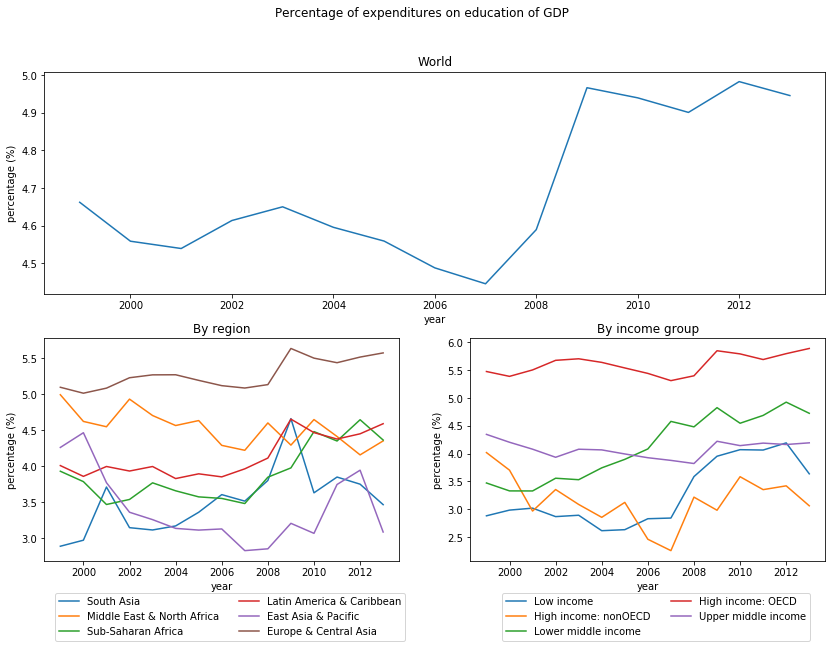

In [294]:
plt.figure(figsize=(14,9))
gs = gridspec.GridSpec(2, 2)
plt.suptitle('Percentage of expenditures on education of GDP')

plt.subplot(gs[0,:])
plt.title('World')
plt.plot(exp_world)
plt.ylabel('percentage (%)')
plt.xlabel('year')

plt.subplot(gs[1,0])
plt.title('By region')
for region in set(exp_df['region']):
    plt.plot(exp_region.loc[(region)])
plt.ylabel('percentage (%)')
plt.xlabel('year')
plt.legend(set(exp_df['region']),ncol=2, loc=(0.03,-0.36))

plt.subplot(gs[1,1])
plt.title('By income group')
for group in set(exp_df['income_group']):
    plt.plot(exp_income.loc[(group)])
plt.ylabel('percentage (%)')
plt.xlabel('year')
plt.legend(set(exp_df['income_group']),ncol=2, loc=(0.09,-0.36))

plt.show()

- link expenditures to education rate
- make world as a thicker (different) line in the two charts

## Infrastructure

In [266]:
infra_ind = new_indicators.loc[new_indicators['topic'] == 'Infrastructure: Communications']
infra_ind

series_code                           topic  \
1549  IT.CMP.PCMP.P2  Infrastructure: Communications   
1550  IT.NET.USER.P2  Infrastructure: Communications   

                           indicator_name  counts  
1549  Personal computers (per 100 people)    2794  
1550      Internet users (per 100 people)    5439

In [314]:
infra_df = int_ed[int_ed['indicator_code'] == 'IT.NET.USER.P2'].drop(columns=['indicator_name','indicator_code'])
infra_df = infra_df[infra_df['year'] >= 1994]
n_years = infra_df['year'].nunique()
year_counts = infra_df.groupby(['country_code'])['value'].count()
lst = year_counts[year_counts == n_years].index
infra_df = infra_df[infra_df['country_code'].isin(lst)]

infra_countries  = infra_df[infra_df['country_code'].isin(countries['country_code'])]
infra_groups = infra_df[~infra_df['country_code'].isin(countries['country_code'])].drop(columns = ['region','income_group'])

infra_table_c = infra_countries.groupby(['country_name','year']).sum()
infra_table_g = infra_groups.groupby(['country_name','year']).sum()


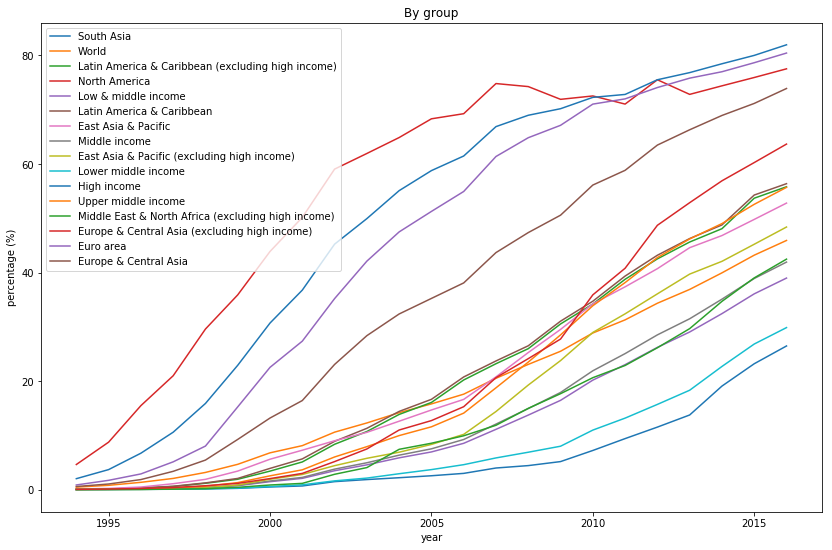

In [320]:
plt.figure(figsize=(14,9))

plt.title('By group')
for group in set(infra_groups['country_name']):
    plt.plot(infra_table_g.loc[(group)])
plt.ylabel('percentage (%)')
plt.xlabel('year')
plt.legend(set(infra_groups['country_name']))

plt.show()

## Teachers

In [419]:
teachers_ind = new_indicators.loc[new_indicators['topic'] == 'Teachers'].sort_values('counts',ascending = False)
teachers_ind

series_code     topic  \
1752  SE.PRM.TCHR          Teachers   
1726  SE.PRM.ENRL.TC.ZS    Teachers   
1753  SE.PRM.TCHR.FE       Teachers   
1754  SE.PRM.TCHR.FE.ZS    Teachers   
1800  SE.SEC.TCHR          Teachers   
1709  SE.PRE.TCHR          Teachers   
1776  SE.SEC.ENRL.TC.ZS    Teachers   
1701  SE.PRE.ENRL.TC.ZS    Teachers   
1843  SE.TER.TCHR          Teachers   
1801  SE.SEC.TCHR.FE       Teachers   
1710  SE.PRE.TCHR.FE       Teachers   
1711  SE.PRE.TCHR.FE.ZS    Teachers   
1802  SE.SEC.TCHR.FE.ZS    Teachers   
1844  SE.TER.TCHR.FE       Teachers   
2447  UIS.PTRHC.56         Teachers   
1845  SE.TER.TCHR.FE.ZS    Teachers   
2439  UIS.PTRHC.2          Teachers   
2444  UIS.PTRHC.3          Teachers   
2234  UIS.FTP.2            Teachers   
2585  UIS.T.2              Teachers   
2235  UIS.FTP.3            Teachers   
2586  UIS.T.2.F            Teachers   
2591  UIS.T.3              Teachers   
2592  UIS.T.3.F            Teachers   
2587  UIS.T.23.GPV         Teachers   
2588  UIS.T.23.GPV.F       Teachers   
1751  SE.PRM.TCAQ.ZS       Teachers   
1750  SE.PRM.TCAQ.MA.ZS    Teachers   
1749  SE.PRM.TCAQ.FE.ZS    Teachers   
2589  UIS.T.23.V           Teachers   
2438  UIS.PTRHC.1.TRAINED  Teachers   

                                                                      indicator_name  \
1752  Teachers in primary education, both sexes (number)                               
1726  Pupil-teacher ratio in primary education (headcount basis)                       
1753  Teachers in primary education, female (number)                                   
1754  Percentage of teachers in primary education who are female (%)                   
1800  Teachers in secondary education, both sexes (number)                             
1709  Teachers in pre-primary education, both sexes (number)                           
1776  Pupil-teacher ratio in secondary education (headcount basis)                     
1701  Pupil-teacher ratio in pre-primary education (headcount basis)                   
1843  Teachers in tertiary education programmes, both sexes (number)                   
1801  Teachers in secondary education, female (number)                                 
1710  Teachers in pre-primary education, female (number)                               
1711  Percentage of teachers in pre-primary education who are female (%)               
1802  Percentage of teachers in secondary education who are female (%)                 
1844  Teachers in tertiary education programmes, female (number)                       
2447  Pupil-teacher ratio in tertiary education (headcount basis)                      
1845  Percentage of teachers in tertiary education who are female (%)                  
2439  Pupil-teacher ratio in lower secondary education (headcount basis)               
2444  Pupil-teacher ratio in upper secondary education (headcount basis)               
2234  Percentage of teachers in lower secondary education who are female (%)           
2585  Teachers in lower secondary education, both sexes (number)                       
2235  Percentage of teachers in upper secondary education who are female (%)           
2586  Teachers in lower secondary education, female (number)                           
2591  Teachers in upper secondary education, both sexes (number)                       
2592  Teachers in upper secondary education, female (number)                           
2587  Teachers in secondary general education, both sexes (number)                     
2588  Teachers in secondary general education, female (number)                         
1751  Percentage of teachers in primary education who are trained, both sexes (%)      
1750  Percentage of male teachers in primary education who are trained, male (%)       
1749  Percentage of female teachers in primary education who are trained, female (%)   
2589  Teachers in secondary vocational education, both sexes (number)                  
2438  Pupil/trained teacher ratio in 

## Learning Outcomes

In [358]:
lo_ind = ['LO.PISA.SCI','LO.PISA.REA','LO.PISA.MAT']
lo_df = int_ed[int_ed['indicator_code'].isin(lo_ind)]

test = lo_df[lo_df['year'] == 2015]

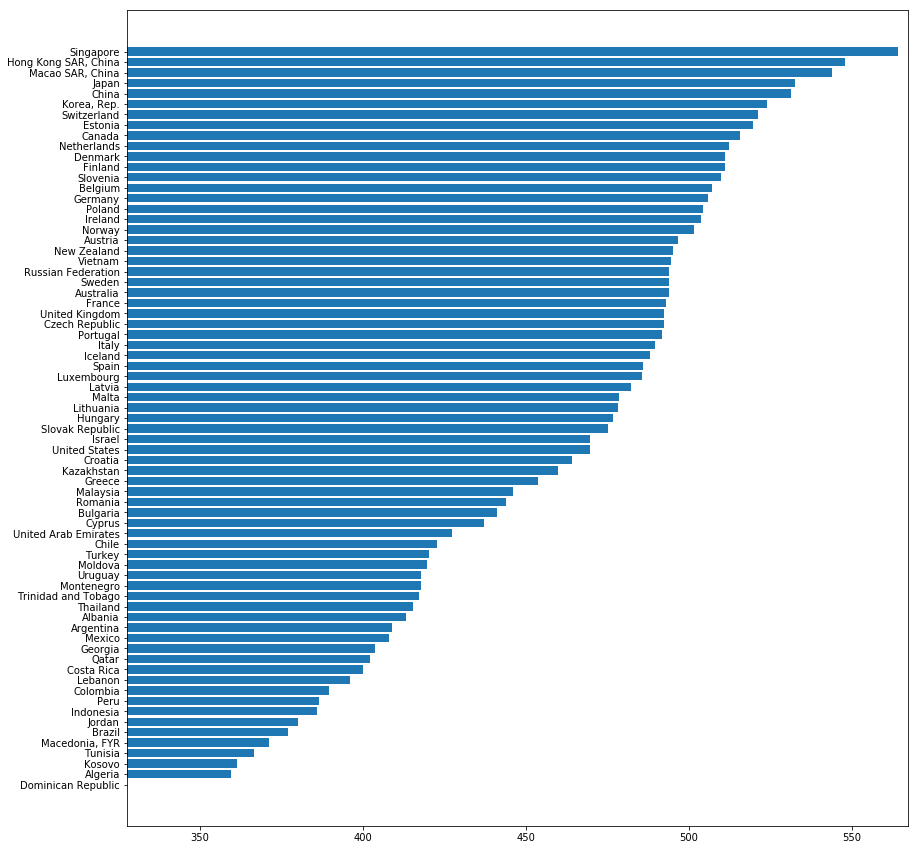

In [389]:
test_math = test[test['indicator_code'] == 'LO.PISA.MAT'].sort_values('value')

plt.figure(figsize = (14,15))
plt.barh(test_math['country_name'],test_math['value'])
plt.xlim(test_math['value'].min(), test_math['value'].max()+3)

plt.show()

## Modeling
1. Prediction
2. feature importance

## Discussion
1. Sparse data, a lot of missing data.

In [307]:
conn = sql.connect('wbed.db')

c = conn.cursor()

c.execute('''CREATE TABLE international_education
             (country_name TEXT, 
              country_code TEXT, 
              indicator_name TEXT, 
              indicator_code TEXT, 
              year INT);''')

c.execute('''CREATE TABLE series_summary
             (series_code TEXT,
              topic TEXT,
              indicator_name TEXT,
              short_definition TEXT);''')

conn.commit()

int_ed.to_sql('international_education', conn, if_exists='replace', index = False)
indicators.to_sql('series_summary', conn, if_exists='replace',index=False)

In [322]:
query = '''
SELECT * 
FROM series_summary'''

result = c.execute(query)
result.fetchall()